In [1006]:
# !pip install xlrd
# !pip install thefuzz
# !pip install geopandas
# !pip install geodatasets

In [1007]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns

# import geopandas as gpd
# import geodatasets as gds

from thefuzz import fuzz
from thefuzz import process
import re

# url = r"C:\Users\PapaYaga\Documents\GitHub\Projects\GSAF5.xls"
url = r"GSAF5.xls"
sharks_df = pd.DataFrame(pd.read_excel(url))

def clean_cols(col):
    """
    Takes a Series as argument, strips it off its whitespaces and capitalizes it.
    """
    col = col.strip()
    col = col.title()
    return col

def fix_m(n):
    """
    Takes a three-value long string and transforms it into an appropriate month number.
    """
    months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    n = process.extractOne(n, months, scorer=fuzz.partial_ratio)[0]
    m_numbers = {months[x]:("0"+str(x+1) if x<9 else str(x+1)) for x in range(12)}
    for m in m_numbers:
        if n == m:
            n = m_numbers[m]
    return n

def clean_date(date):
    """
    Takes a Series as argument, cleans it.
    """
    check = re.findall("\d\d.\D\D{3}\d{4}|\d\d.\D\D{3}|\d{4}", str(date))
    if check:
        try:
            check = check[0].replace(" ","-")
            month = re.findall("[a-zA-Z]{3}",str(check))[0]
            month_new = fix_m(month)
            check = check.replace(month, str(month_new))
            check = f"{check[:2]}-{check[3:5]}-{check[6:]}"
        except IndexError:
            if check == "1018":
                check = "2018"
            elif check >= "2024":
                check = "1959"
            return str(check)
        else:
            return str(check)
    else:
        return ""

def clean_type(type):
    """

    """
    type_dict = {"Unprovoked":"Unprovoked",
             "Provoked":"Provoked",
             "Invalid":"Invalid",
             "Watercraft":"Watercraft",
             "Sea Disaster":"Sea_Disaster",
             "Questionable":"Invalid",
             "Boat":"Watercraft",
             " Provoked":"Provoked",
             "?":"Invalid",
             "Unconfirmed":"Invalid",
             "Unverified":"Invalid",
             "Under investigation":"Invalid",}
    return type.map(type_dict)

def clean_ctr(ctr):
    """
    
    """
    ctr = str(ctr).title().strip()
    ctr = ctr.replace("?","").replace("(Uae)","").replace("St ","St. ")
    if ctr == "Iran / Iraq":
        ctr = "Iran"
    elif ctr == "Ceylon (Sri Lanka)":
        ctr = "Sri Lanka"
    return ctr
    
sharks_df.columns = pd.Series(sharks_df.columns).apply(clean_cols)

In [1008]:
sharks_df["Date"] = sharks_df["Date"].apply(lambda x: clean_date(x))
# sharks_df["Year"] = sharks_df["Date"].apply(lambda x: re.findall("[0-9]{4}", x)[0] if x else x)
sharks_df["Year"] = sharks_df["Year"].apply(lambda x: str(x).replace(".0",""))
sharks_df["Date"] = pd.to_datetime(sharks_df["Date"],format="mixed", errors="coerce")
sharks_df.set_index(["Date"], inplace=True, drop=True)

In [1009]:
sharks_df["Type"] = clean_type(sharks_df["Type"])
sharks_df["Country"] = sharks_df["Country"].apply(clean_ctr)
sharks_df["State"] = sharks_df["State"].apply(clean_ctr)

In [1010]:
sharks_rdx = sharks_df[["Year","Type","Country","State","Location","Activity","Name","Sex","Age","Injury","Species","Source"]]
sharks_rdx.dropna(thresh=7, inplace=True)
sharks_rdx.sort_index(ascending=False, inplace=True)
sharks_rdx.drop_duplicates(inplace=True)

[Text(0.5, 1.0, 'Amount of states per country')]

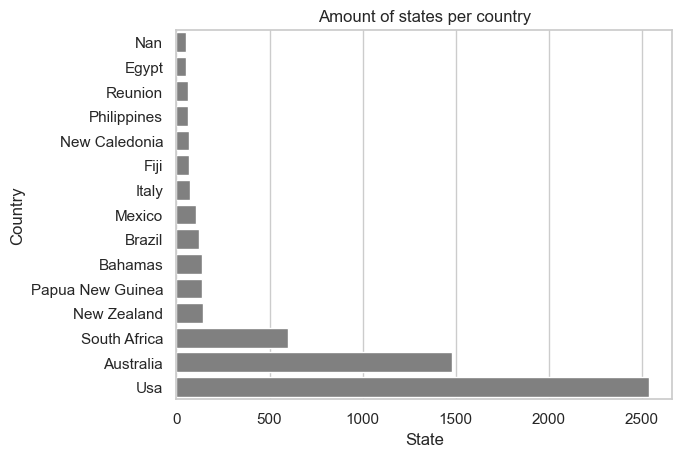

In [1011]:
state_amount = sharks_rdx.groupby(["Country"])["State"].size().sort_values().tail(15)
state_amount_x = sharks_rdx["Country"].value_counts().sort_values().tail(15)

sns.set_theme(style="whitegrid")
sns.barplot(x=state_amount, y=state_amount_x.index,color="gray").set(title="Amount of states per country")

In [1012]:
years = {x:y for x,y in sharks_rdx["Year"].value_counts().items()}
years_df = pd.DataFrame(sorted(years.items(), reverse=True))
years_df.set_index(0,inplace=True)

C:\Users\PariahJack\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PariahJack\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


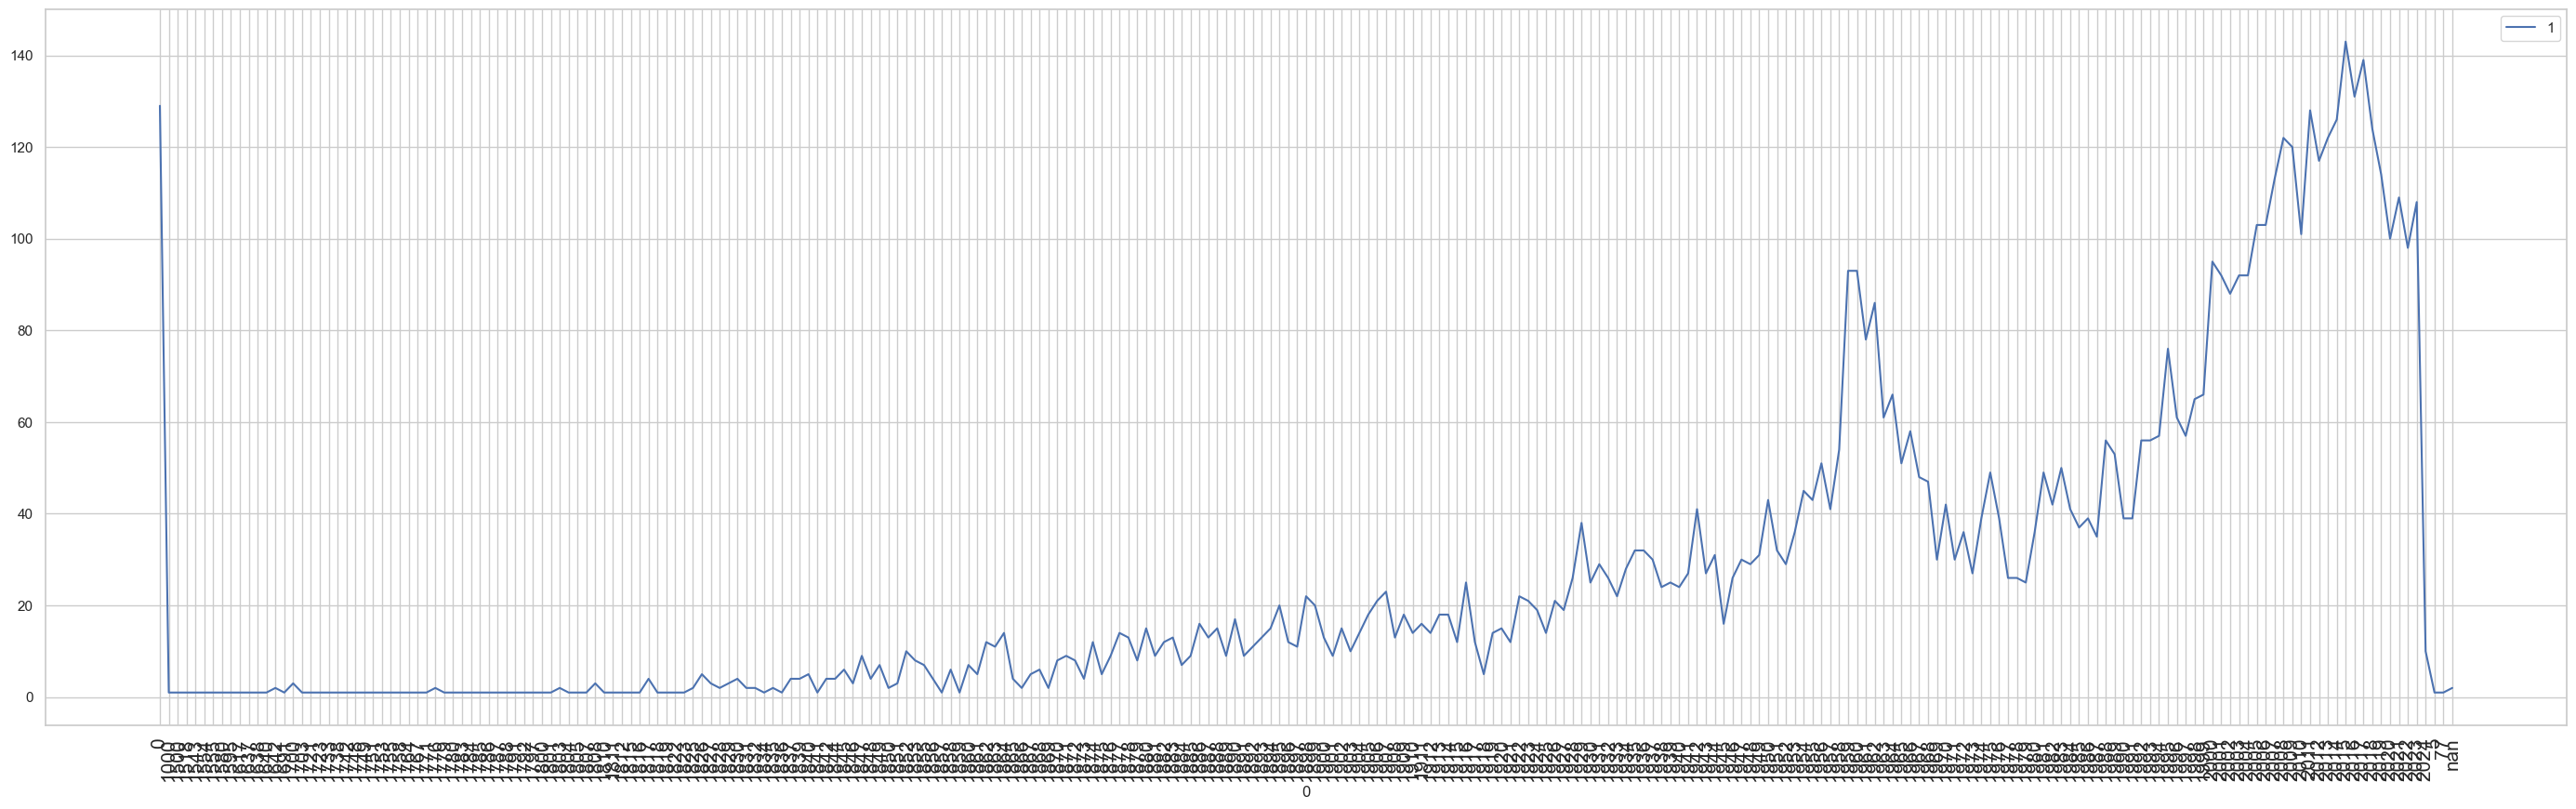

In [1014]:
plt.figure(figsize=(35, 10))
plt.xticks(size = 15, rotation = 90)
sns.lineplot(data=years_df, color="gray").invert_xaxis()